# Introduction

In the [Notebook](hello_poisson.ipynb) we introduced the basic process of
solving the Poisson problem with constant source. This seemed to work just fine,
but giving the prior existence of FEM solving software packages why have we gone
to all the additional work of implementing these methods inside of the Tensorflow
ecosystem? In this notebook we being to make this abit clearer by considering a
much more interesting class of models obtained by replacing the relatively
boring source of the previous examples with the tensorflow implementation of the
`GaussianProcess` class. That is we shall consider the solution of PDE systems of the
form

$$
\begin{align}
    -\nabla ( a(x) \nabla u(x) ) = f(x), \qquad f(x) \sim \mathcal{GP}(0, k),
\end{align}
$$

where the source function is now a mean zero Gaussian process with kernel function $k$.
We show that it is simple to put together this model, and for the cost of implementing
the FEM solver we have gained access to the full set of statistical and machine learning
models implemented in TensorFlow

In [56]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
tf.keras.backend.set_floatx('float64')
import tenfem
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.tri import Triangulation
from tenfem.layers import (AssembleStiffnessMatrix, AssembleLoadVector, SolveDirichletProblem,
                           TriangleMeshInterpolator)

tf_dtype = tf.float64
tfk = tf.keras
tfkl = tf.keras.layers
tfpl = tfp.layers

tf.random.set_seed(321)

num_inducing_points = 10

# Creating the GP model


## The kernel function
In this example we shall take the kernel function of our Gaussian process to be popular
exponentiated quadratic, or radial basis function (RBF) kernel

$$
    k(x, x') = \alpha^2 \exp\left(-\frac{1}{2} \sum_{d=1}^D (x_d - x'_d ) / \ell_d^2 \right)
$$

where $\alpha$ is the *amplitude* parameter, and $\ell$ is the *length-scale* parameter. 

We want to implement the GP model inside of the `tf.keras` functional API using the layers
created by the `tensorflow_probability` team. To do so we are going to need a layer whose
job is provide the kernel function to the Gaussian process. This layers job is to hold the
model parameters, and simple layer class to do this job taken from 
the [tfp examples]() is given below

In [2]:
class RBFKernelFn(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(RBFKernelFn, self).__init__(**kwargs)
        dtype = kwargs.get('dtype', None)

        self._amplitude = self.add_weight(
                initializer=tf.constant_initializer(0),
                dtype=dtype,
                name='amplitude')

        self._length_scale = self.add_weight(
                initializer=tf.constant_initializer(0.5),
                dtype=dtype,
                name='length_scale')

    def call(self, x):
        # Never called -- this is just a layer so it can hold variables
        # in a way Keras understands.
        return x

    @property
    def kernel(self):
        return tfp.math.psd_kernels.ExponentiatedQuadratic(
          amplitude=tf.nn.softplus(0.1 * self._amplitude),
          length_scale=tf.nn.softplus(.1 * self._length_scale)
        )

## `VariationalGaussianProcess`

Read more about these process at 

### Domain creation
Before proceeding to define this part of the model, lets create our problem domain
$\Omega$, again we will use a simple example mesh which is the unit square
$\Omega = [0, 1] \times [0, 1]$. We will also rescale this domain to give our 
GP variables some "wiggle" room.

In [3]:
mesh = tenfem.mesh.examples.square(20, 20, dtype=tf_dtype)
# rescale the mesh a bit
mesh = tenfem.mesh.TriangleMesh(3. * mesh.nodes,
                                mesh.elements,
                                mesh.boundary_elements)
mesh.add_matplotlib_tri()

### `VariationalGaussianProcess`

We are going to initialise the locations of the inducing points at the a 
selection of randomly sampled nodes on the mesh, and the distribution
$q(\mathbf{u})$ at the prior

In [4]:
# select the initial inducing points uniformly from the mesh node
z_indices = np.random.choice(mesh.interior_node_indices.numpy(), 
                             size=num_inducing_points, 
                             replace=False)
z = mesh.nodes.numpy()[z_indices]

# initialize q(u) at the prior
kernel_provider = RBFKernelFn(dtype=tf.float64)
kzz = kernel_provider.kernel.matrix(z, z)
scale = tf.linalg.cholesky(kzz).numpy()

# initialize q(u) at the prior
kernel_provider = RBFKernelFn(dtype=tf.float64)
kzz = kernel_provider.kernel.matrix(z, z)
scale = tf.linalg.cholesky(kzz).numpy()

In [5]:
gp_layer = tfp.layers.VariationalGaussianProcess(
    num_inducing_points=num_inducing_points,
    kernel_provider=kernel_provider,
    event_shape=[1],
    inducing_index_points_initializer=tf.constant_initializer(z),
    variational_inducing_observations_scale_initializer=tf.constant_initializer(scale),
    jitter=1e-4)

We are also going to add a further layer transforming our inputs to the parameters
of the kernel function
```
    Input ---> Dense(2) ---> VariationalGaussianProcess
```
This layer does simple rescaling of the parameters, but obviously one is
free to extend this idea adding more and more layers to warp the input space
which will be points in $\Omega$. Clearly this approach to model building can be
easily adapted to join multiple spaces etc.

We leave the exploration of the full possibilities for the reader and future notebooks
and for now just implement the simple model shown above. We can put the source
together as a full model and use the `.summary()` method to check everything is
working as expected.

In [6]:
inputs = tfkl.Input(2)
x = tfkl.Dense(2, use_bias=False)(inputs)  # scales inputs (like a length_scale)
f = gp_layer(x)
source = tfk.Model(inputs=inputs, outputs=f, name='source')
source.summary()

Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.


/Users/danieltait/anaconda3/envs/tenfem/lib/python3.7/site-packages/tensorflow_probability/python/distributions/gaussian_process.py:311: UserWarning: Unable to detect statically whether the number of index_points is 1. As a result, defaulting to treating the marginal GP at `index_points` as a multivariate Gaussian. This makes some methods, like `cdf` unavailable.
  'Unable to detect statically whether the number of index_points is '


Model: "source"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense (Dense)                (None, 2)                 4         
_________________________________________________________________
variational_gaussian_process ((None, 1), (None, 1))    134       
Total params: 138
Trainable params: 138
Non-trainable params: 0
_________________________________________________________________


# Implementing the FEM model

In [7]:
gp_layer = tfp.layers.VariationalGaussianProcess(
    num_inducing_points=num_inducing_points,
    kernel_provider=RBFKernelFn(),
    event_shape=[1],
    inducing_index_points_initializer=tf.constant_initializer(z),
    variational_inducing_observations_scale_initializer=tf.constant_initializer(scale),
    jitter=1e-4)

inputs = tfkl.Input(2)
#x = tfkl.Dense(2, use_bias=False)(inputs)  # scales inputs (like a length_scale)
f = gp_layer(inputs)

ud = tfk.Model(inputs=inputs, outputs=f, name='boundary')
ud.summary()

Model: "boundary"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
variational_gaussian_process ((None, 1), (None, 1))    134       
Total params: 134
Trainable params: 134
Non-trainable params: 0
_________________________________________________________________


In [8]:
element = tenfem.reference_elements.TriangleElement(degree=2, dtype=tf_dtype)
quad_mesh = tenfem.mesh.triangle.convert_linear_to_quadratic(mesh)

#ud = lambda x: tf.zeros_like(x)[..., 0, tf.newaxis]

diffusion_coefficient = tfkl.Dense(1, activation='softplus')

def sample_source(x, seed=123):
    tf.random.set_seed(seed)
    return np.squeeze(source(x).sample(1))

def solve(mesh, element, seed=123):
    """ Simple function so solve the PDE"""
    tf.random.set_seed(seed)
    mesh_tensor_repr = mesh.get_tensor_repr()

    stiffness_matrix = AssembleStiffnessMatrix(diffusion_coefficient,
                                               reference_element=element)(mesh_tensor_repr)
    load_vector = AssembleLoadVector(source,
                                     reference_element=element)(mesh_tensor_repr)
    node_types = mesh_tensor_repr[-1]
    boundary_values = ud(tf.gather_nd(mesh.nodes, tf.where(node_types == 1)))

    return tenfem.fem.solve_dirichlet_form_linear_system(
        stiffness_matrix[0], load_vector[0], node_types, boundary_values)

In [9]:
f = sample_source(quad_mesh.nodes)
u = solve(quad_mesh, element)

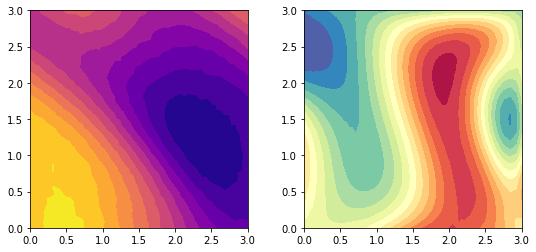

In [11]:
fig, axes = plt.subplots(ncols=2, figsize=(9, 4))

mtri = Triangulation(*quad_mesh.nodes.numpy().T)

vals = [f, u[:, 0]]
cm = ['plasma', 'Spectral']

for i, ax in enumerate(axes):
    cs = ax.tricontourf(mtri, vals[i], cmap=cm[i], levels=15)
    ax.set_aspect('equal')

plt.show()

In [13]:
from sklearn.datasets import fetch_species_distributions


In [16]:
def construct_grids(batch):
    """Construct the map grid from the batch object

    Parameters
    ----------
    batch : Batch object
        The object returned by :func:`fetch_species_distributions`

    Returns
    -------
    (xgrid, ygrid) : 1-D arrays
        The grid corresponding to the values in batch.coverages
    """
    # x,y coordinates for corner cells
    xmin = batch.x_left_lower_corner + batch.grid_size
    xmax = xmin + (batch.Nx * batch.grid_size)
    ymin = batch.y_left_lower_corner + batch.grid_size
    ymax = ymin + (batch.Ny * batch.grid_size)

    # x coordinates of the grid cells
    xgrid = np.arange(xmin, xmax, batch.grid_size)
    # y coordinates of the grid cells
    ygrid = np.arange(ymin, ymax, batch.grid_size)

    return (xgrid, ygrid)

# Get matrices/arrays of species IDs and locations
data = fetch_species_distributions()
species_names = ['Bradypus Variegatus', 'Microryzomys Minutus']

Xtrain = np.vstack([data['train']['dd lat'],
                    data['train']['dd long']]).T
ytrain = np.array([d.decode('ascii').startswith('micro')
                  for d in data['train']['species']], dtype='int')
#Xtrain *= np.pi / 180.  # Convert lat/long to radians

# Set up the data grid for the contour plot
xgrid, ygrid = construct_grids(data)

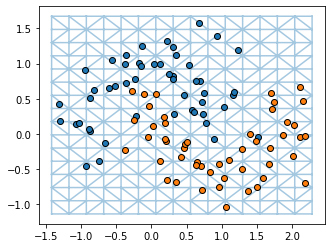

In [178]:
from scipy.spatial import Delaunay
from sklearn.datasets import make_moons

data = make_moons(noise=0.3, random_state=0)

X, y = data

bbox = (np.min(X[:, 0]) - 0.1, 
        np.max(X[:, 0]) + 0.1, 
        np.min(X[:, 1]) - 0.1, 
        np.max(X[:, 1]) + 0.1)

xx = np.linspace(bbox[0], bbox[1], 16)
yy = np.linspace(bbox[2], bbox[3], 16)

xx, yy = np.meshgrid(xx, yy)

nodes = np.column_stack((xx.ravel(), yy.ravel()))
tri = Delaunay(nodes)

tri_mesh = tenfem.mesh.TriangleMesh(tri.points, tri.simplices, tri.convex_hull, dtype=tf_dtype)
tri_mesh.add_matplotlib_tri()

fig, ax = plt.subplots()
ax.triplot(tri_mesh._triang, alpha=0.4)
ax.set_aspect('equal')
ax.plot(*X[y == 0].T, 'C0o', markeredgecolor='k')
ax.plot(*X[y == 1].T, 'C1o', markeredgecolor='k')
plt.show()

In [201]:
tfd = tfp.distributions

gp_layer = tfp.layers.VariationalGaussianProcess(
    num_inducing_points=num_inducing_points,
    kernel_provider=RBFKernelFn(),
    event_shape=[1],
    inducing_index_points_initializer=tf.constant_initializer(z),
    variational_inducing_observations_scale_initializer=tf.constant_initializer(scale),
    jitter=1e-4)

inputs = tfkl.Input(2)
x = tfkl.Dense(2)(inputs)  # scales inputs (like a length_scale)
f = tfkl.Dense(16, activation='relu')(x)
f = tfkl.Dense(16, activation='relu')(f)
pred = tfkl.Dense(2)(f)
#f = gp_layer(x)
#pred = tfpl.IndependentBernoulli(event_shape=(), convert_to_tensor_fn=tfd.Bernoulli.logits)(f)

model = tfk.Model(inputs=inputs, outputs=pred)

negative_log_likelihood = lambda x, rv_x: -rv_x.log_prob(x)

model.summary()

model.compile(optimizer=tf.optimizers.Adam(learning_rate=1e-3),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics='accuracy')

Model: "model_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_31 (InputLayer)        [(None, 2)]               0         
_________________________________________________________________
dense_75 (Dense)             (None, 2)                 6         
_________________________________________________________________
dense_76 (Dense)             (None, 16)                48        
_________________________________________________________________
dense_77 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_78 (Dense)             (None, 2)                 34        
Total params: 360
Trainable params: 360
Non-trainable params: 0
_________________________________________________________________


In [206]:
model.fit(X, y[:, None], batch_size=128, epochs=1000)

Epoch 1/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0925 - accuracy: 0.9600
Epoch 2/1000
1/1 [==============================] - 0s 920us/step - loss: 0.0925 - accuracy: 0.9600
Epoch 3/1000
1/1 [==============================] - 0s 971us/step - loss: 0.0924 - accuracy: 0.9600
Epoch 4/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0924 - accuracy: 0.9600
Epoch 5/1000
1/1 [==============================] - 0s 887us/step - loss: 0.0923 - accuracy: 0.9600
Epoch 6/1000
1/1 [==============================] - 0s 897us/step - loss: 0.0923 - accuracy: 0.9600
Epoch 7/1000
1/1 [==============================] - 0s 916us/step - loss: 0.0923 - accuracy: 0.9600
Epoch 8/1000
1/1 [==============================] - 0s 838us/step - loss: 0.0923 - accuracy: 0.9600
Epoch 9/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0922 - accuracy: 0.9600
Epoch 10/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0922 - accuracy: 0.9600
Epoch 1

1/1 [==============================] - 0s 935us/step - loss: 0.0899 - accuracy: 0.9600
Epoch 83/1000
1/1 [==============================] - 0s 736us/step - loss: 0.0899 - accuracy: 0.9600
Epoch 84/1000
1/1 [==============================] - 0s 749us/step - loss: 0.0899 - accuracy: 0.9600
Epoch 85/1000
1/1 [==============================] - 0s 969us/step - loss: 0.0899 - accuracy: 0.9600
Epoch 86/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0899 - accuracy: 0.9600
Epoch 87/1000
1/1 [==============================] - 0s 921us/step - loss: 0.0898 - accuracy: 0.9600
Epoch 88/1000
1/1 [==============================] - 0s 753us/step - loss: 0.0898 - accuracy: 0.9600
Epoch 89/1000
1/1 [==============================] - 0s 895us/step - loss: 0.0898 - accuracy: 0.9600
Epoch 90/1000
1/1 [==============================] - 0s 915us/step - loss: 0.0897 - accuracy: 0.9600
Epoch 91/1000
1/1 [==============================] - 0s 928us/step - loss: 0.0897 - accuracy: 0.9600
Epoch 

1/1 [==============================] - 0s 1ms/step - loss: 0.0881 - accuracy: 0.9600
Epoch 164/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0881 - accuracy: 0.9600
Epoch 165/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0881 - accuracy: 0.9600
Epoch 166/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0881 - accuracy: 0.9600
Epoch 167/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0880 - accuracy: 0.9600
Epoch 168/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0880 - accuracy: 0.9600
Epoch 169/1000
1/1 [==============================] - 0s 813us/step - loss: 0.0880 - accuracy: 0.9600
Epoch 170/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0880 - accuracy: 0.9600
Epoch 171/1000
1/1 [==============================] - 0s 769us/step - loss: 0.0880 - accuracy: 0.9600
Epoch 172/1000
1/1 [==============================] - 0s 761us/step - loss: 0.0880 - accuracy: 0.9600
Epoch 173

1/1 [==============================] - 0s 830us/step - loss: 0.0867 - accuracy: 0.9600
Epoch 244/1000
1/1 [==============================] - 0s 884us/step - loss: 0.0867 - accuracy: 0.9600
Epoch 245/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0867 - accuracy: 0.9600
Epoch 246/1000
1/1 [==============================] - 0s 842us/step - loss: 0.0867 - accuracy: 0.9600
Epoch 247/1000
1/1 [==============================] - 0s 817us/step - loss: 0.0867 - accuracy: 0.9600
Epoch 248/1000
1/1 [==============================] - 0s 871us/step - loss: 0.0866 - accuracy: 0.9600
Epoch 249/1000
1/1 [==============================] - 0s 855us/step - loss: 0.0866 - accuracy: 0.9600
Epoch 250/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0866 - accuracy: 0.9600
Epoch 251/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0866 - accuracy: 0.9600
Epoch 252/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0866 - accuracy: 0.9600
Epo

1/1 [==============================] - 0s 971us/step - loss: 0.0855 - accuracy: 0.9600
Epoch 325/1000
1/1 [==============================] - 0s 731us/step - loss: 0.0855 - accuracy: 0.9600
Epoch 326/1000
1/1 [==============================] - 0s 897us/step - loss: 0.0855 - accuracy: 0.9600
Epoch 327/1000
1/1 [==============================] - 0s 848us/step - loss: 0.0854 - accuracy: 0.9600
Epoch 328/1000
1/1 [==============================] - 0s 767us/step - loss: 0.0854 - accuracy: 0.9600
Epoch 329/1000
1/1 [==============================] - 0s 750us/step - loss: 0.0854 - accuracy: 0.9600
Epoch 330/1000
1/1 [==============================] - 0s 960us/step - loss: 0.0854 - accuracy: 0.9600
Epoch 331/1000
1/1 [==============================] - 0s 882us/step - loss: 0.0854 - accuracy: 0.9600
Epoch 332/1000
1/1 [==============================] - 0s 905us/step - loss: 0.0854 - accuracy: 0.9600
Epoch 333/1000
1/1 [==============================] - 0s 820us/step - loss: 0.0854 - accuracy: 0.

1/1 [==============================] - 0s 1ms/step - loss: 0.0844 - accuracy: 0.9600
Epoch 404/1000
1/1 [==============================] - 0s 748us/step - loss: 0.0844 - accuracy: 0.9600
Epoch 405/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0844 - accuracy: 0.9600
Epoch 406/1000
1/1 [==============================] - 0s 921us/step - loss: 0.0844 - accuracy: 0.9600
Epoch 407/1000
1/1 [==============================] - 0s 725us/step - loss: 0.0844 - accuracy: 0.9600
Epoch 408/1000
1/1 [==============================] - 0s 798us/step - loss: 0.0843 - accuracy: 0.9600
Epoch 409/1000
1/1 [==============================] - 0s 900us/step - loss: 0.0843 - accuracy: 0.9600
Epoch 410/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0843 - accuracy: 0.9600
Epoch 411/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0843 - accuracy: 0.9600
Epoch 412/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0843 - accuracy: 0.9600
Epoch

1/1 [==============================] - 0s 841us/step - loss: 0.0834 - accuracy: 0.9600
Epoch 484/1000
1/1 [==============================] - 0s 881us/step - loss: 0.0834 - accuracy: 0.9600
Epoch 485/1000
1/1 [==============================] - 0s 804us/step - loss: 0.0834 - accuracy: 0.9600
Epoch 486/1000
1/1 [==============================] - 0s 801us/step - loss: 0.0833 - accuracy: 0.9600
Epoch 487/1000
1/1 [==============================] - 0s 779us/step - loss: 0.0834 - accuracy: 0.9600
Epoch 488/1000
1/1 [==============================] - 0s 923us/step - loss: 0.0833 - accuracy: 0.9600
Epoch 489/1000
1/1 [==============================] - 0s 837us/step - loss: 0.0833 - accuracy: 0.9600
Epoch 490/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0833 - accuracy: 0.9600
Epoch 491/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0833 - accuracy: 0.9600
Epoch 492/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0832 - accuracy: 0.9600
E

Epoch 564/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0823 - accuracy: 0.9700
Epoch 565/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0823 - accuracy: 0.9700
Epoch 566/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0823 - accuracy: 0.9700
Epoch 567/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0823 - accuracy: 0.9700
Epoch 568/1000
1/1 [==============================] - 0s 790us/step - loss: 0.0823 - accuracy: 0.9700
Epoch 569/1000
1/1 [==============================] - 0s 830us/step - loss: 0.0822 - accuracy: 0.9700
Epoch 570/1000
1/1 [==============================] - ETA: 0s - loss: 0.0822 - accuracy: 0.97 - 0s 1ms/step - loss: 0.0822 - accuracy: 0.9700
Epoch 571/1000
1/1 [==============================] - 0s 996us/step - loss: 0.0822 - accuracy: 0.9700
Epoch 572/1000
1/1 [==============================] - 0s 925us/step - loss: 0.0822 - accuracy: 0.9700
Epoch 573/1000
1/1 [==============================

1/1 [==============================] - 0s 889us/step - loss: 0.0813 - accuracy: 0.9700
Epoch 645/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0813 - accuracy: 0.9700
Epoch 646/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0813 - accuracy: 0.9700
Epoch 647/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0812 - accuracy: 0.9700
Epoch 648/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0812 - accuracy: 0.9700
Epoch 649/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.0812 - accuracy: 0.9700
Epoch 650/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0812 - accuracy: 0.9700
Epoch 651/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0812 - accuracy: 0.9700
Epoch 652/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0812 - accuracy: 0.9700
Epoch 653/1000
1/1 [==============================] - 0s 918us/step - loss: 0.0812 - accuracy: 0.9700
Epoch 654/1

1/1 [==============================] - 0s 1ms/step - loss: 0.0802 - accuracy: 0.9700
Epoch 726/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0802 - accuracy: 0.9700
Epoch 727/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0802 - accuracy: 0.9700
Epoch 728/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0802 - accuracy: 0.9700
Epoch 729/1000
1/1 [==============================] - 0s 770us/step - loss: 0.0802 - accuracy: 0.9700
Epoch 730/1000
1/1 [==============================] - 0s 927us/step - loss: 0.0802 - accuracy: 0.9700
Epoch 731/1000
1/1 [==============================] - 0s 807us/step - loss: 0.0801 - accuracy: 0.9700
Epoch 732/1000
1/1 [==============================] - 0s 757us/step - loss: 0.0801 - accuracy: 0.9700
Epoch 733/1000
1/1 [==============================] - 0s 785us/step - loss: 0.0801 - accuracy: 0.9700
Epoch 734/1000
1/1 [==============================] - 0s 809us/step - loss: 0.0801 - accuracy: 0.9700
Epo

Epoch 806/1000
1/1 [==============================] - 0s 974us/step - loss: 0.0792 - accuracy: 0.9700
Epoch 807/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.0792 - accuracy: 0.9700
Epoch 808/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0792 - accuracy: 0.9700
Epoch 809/1000
1/1 [==============================] - 0s 947us/step - loss: 0.0792 - accuracy: 0.9700
Epoch 810/1000
1/1 [==============================] - 0s 880us/step - loss: 0.0792 - accuracy: 0.9700
Epoch 811/1000
1/1 [==============================] - 0s 935us/step - loss: 0.0792 - accuracy: 0.9700
Epoch 812/1000
1/1 [==============================] - 0s 897us/step - loss: 0.0792 - accuracy: 0.9700
Epoch 813/1000
1/1 [==============================] - 0s 865us/step - loss: 0.0791 - accuracy: 0.9700
Epoch 814/1000
1/1 [==============================] - 0s 858us/step - loss: 0.0791 - accuracy: 0.9700
Epoch 815/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.0791 - acc

Epoch 887/1000
1/1 [==============================] - 0s 735us/step - loss: 0.0782 - accuracy: 0.9700
Epoch 888/1000
1/1 [==============================] - 0s 916us/step - loss: 0.0783 - accuracy: 0.9700
Epoch 889/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0782 - accuracy: 0.9700
Epoch 890/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0782 - accuracy: 0.9700
Epoch 891/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0782 - accuracy: 0.9700
Epoch 892/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0782 - accuracy: 0.9700
Epoch 893/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0782 - accuracy: 0.9700
Epoch 894/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0781 - accuracy: 0.9700
Epoch 895/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0781 - accuracy: 0.9700
Epoch 896/1000
1/1 [==============================] - 0s 822us/step - loss: 0.0781 - accuracy: 0

1/1 [==============================] - 0s 1ms/step - loss: 0.0769 - accuracy: 0.9700
Epoch 968/1000
1/1 [==============================] - 0s 881us/step - loss: 0.0768 - accuracy: 0.9700
Epoch 969/1000
1/1 [==============================] - 0s 894us/step - loss: 0.0768 - accuracy: 0.9700
Epoch 970/1000
1/1 [==============================] - 0s 775us/step - loss: 0.0768 - accuracy: 0.9700
Epoch 971/1000
1/1 [==============================] - 0s 1000us/step - loss: 0.0768 - accuracy: 0.9700
Epoch 972/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0768 - accuracy: 0.9700
Epoch 973/1000
1/1 [==============================] - 0s 922us/step - loss: 0.0768 - accuracy: 0.9700
Epoch 974/1000
1/1 [==============================] - 0s 906us/step - loss: 0.0768 - accuracy: 0.9700
Epoch 975/1000
1/1 [==============================] - 0s 938us/step - loss: 0.0768 - accuracy: 0.9700
Epoch 976/1000
1/1 [==============================] - 0s 945us/step - loss: 0.0767 - accuracy: 0.970

In [207]:
pred = model.predict(tri_mesh.nodes)

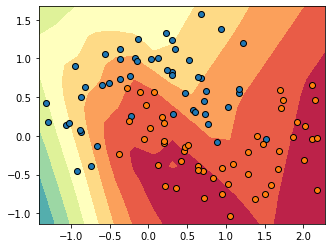

In [218]:
fig, ax = plt.subplots()
ax.contourf(xx, yy, pred[:, 0].reshape(xx.shape), cmap='Spectral')
ax.plot(*X[y == 0].T, 'C0o', markeredgecolor='k')
ax.plot(*X[y == 1].T, 'C1o', markeredgecolor='k')
ax.set_aspect('equal')
plt.show()

In [93]:
y.shape[1:]

()

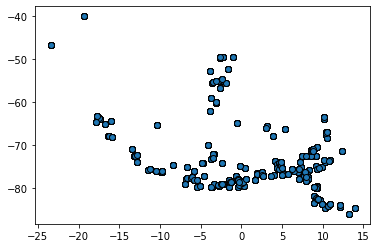

In [19]:
fig, ax = plt.subplots()
ax.plot(*Xtrain.T, 'o', markeredgecolor='k')

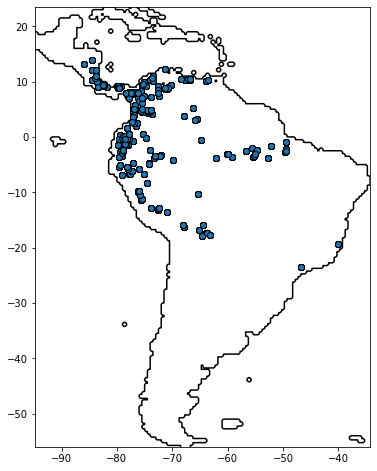

In [37]:
X, Y = np.meshgrid(xgrid[::5], ygrid[::5][::-1])
land_reference = data.coverages[6][::5, ::5]
land_mask = (land_reference > 0).ravel()

fig, ax = plt.subplots(figsize=(6, 10))
ax.contour(X, Y, land_reference,
            levels=[-9998], colors="k",
            linestyles="solid")

ax.plot(Xtrain[:, 1], Xtrain[:, 0], 'o', markeredgecolor='k')

ax.set_aspect('equal')

(array([[307.,   0.,   0., ...,   0.,   0.,  12.],
        [307.,   0.,   0., ...,   0.,   0.,  12.],
        [309.,   0.,   0., ...,   0.,   0.,  10.],
        ...,
        [313.,   0.,   0., ...,   0.,   0.,   6.],
        [313.,   0.,   0., ...,   0.,   0.,   6.],
        [319.,   0.,   0., ...,   0.,   0.,   0.]]),
 array([-9999., -8979., -7959., -6939., -5919., -4899., -3879., -2859.,
        -1839.,  -819.,   201.]),
 <a list of 243 Lists of Patches objects>)

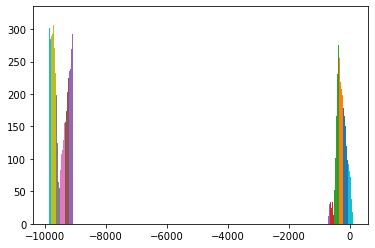

In [30]:
plt.hist(land_reference)